# Workshop 2: Clinical Variables & Feature Engineering

### Data Analysis:

Once we understand the problem, we have formed a multidisciplinary team, formulated the research question and our hypothesis (workshop 1), we have to start working with the data. What data do we have? How do they look? What distributions do they have?

Let's remember that in data science, data is the most important thing, and whether or not we can solve a problem depends on the data quality. At the same time, understanding the data also helps us to have a clearer vision of what we are facing and in case the data is not very good, we can at least fix it.

Specifically, understanding the problem and the data are the essential phases in a data science project. An error in this phase is much more critical than an error in the modeling and evaluation phases. We must bear in mind that machine learning is not a magical tool that solves any type of problem, but rather a mathematical/statistical tool that learns from what we teach it, therefore if the data has biases, the model will also have them.

### Setup environment

In [1]:
#!pip install --upgrade ipykernel

In [2]:
# Data reading in Dataframe format and data preprocessing
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For missing values
import missingno as msno

# Linear algebra operations
import numpy as np

# Machine learning models and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/MIMIC_IV
!ls

/content/drive/MyDrive/MIMIC_IV
columns_dictionary.csv	   get_MimicIV.ipynb		   oxygen_dataset
columns_dictionary.gsheet  MIMIC_Data_Preprocessing.ipynb
generate_dict.ipynb	   mimiciv_full


In [6]:
# Dataset Path:
PATH = 'oxygen_dataset/MIMIC_IV.csv'

### Read the dataset

In [7]:
def null_values(df):
  """ 
  This function checks if there are null values in the dataframe:
  In case of not having null values, print: 'There aren't null values in the dataframe'
  In case of having null values, print the columns with these values
  """
  
  nulos = df.isnull().sum().any()
  if nulos == False:
    print("There aren't null values in the dataframe")
  else:
    print('Null values: ')
    print(df.isnull().sum()[df.isnull().sum()  > 0])

In [8]:
# Read file
df = pd.read_csv(PATH)
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

# Check if there are null values
null_values(df)

# Print first 5 rows
df.head()

The dataset has 81797 rows and 138 columns
Null values: 
weight                 6827
height                15693
BMI                   15958
delta_vent_start      10070
ventilation_status    10070
                      ...  
temperature             961
delta_glucose            13
glucose                  13
delta_heart_rhythm       12
heart_rhythm             12
Length: 102, dtype: int64


,subject_id,stay_id,SaO2_timestamp,SaO2,delta_SpO2,SpO2,hidden_hypoxemia,hadm_id,gender,sex_female,...,delta_mbp,mbp,delta_resp_rate,resp_rate,delta_temperature,temperature,delta_glucose,glucose,delta_heart_rhythm,heart_rhythm
0,10001884,37510196,2131-01-12 21:04:00,90.0,-4,89,0,26184834,F,1,...,-3,96.0,-4.0,19.5,-64.0,36.72,445.0,199.0,-4.0,SR (Sinus Rhythm)
1,10001884,37510196,2131-01-13 02:28:00,92.0,-28,94,0,26184834,F,1,...,-27,98.0,-28.0,22.0,92.0,36.56,121.0,199.0,-28.0,SR (Sinus Rhythm)
2,10002013,39060235,2160-05-18 16:03:00,99.0,0,99,0,23581541,F,1,...,-3,86.5,-2.0,14.0,-3.0,36.90,0.0,155.0,-3.0,SR (Sinus Rhythm)
3,10002013,39060235,2160-05-18 17:42:00,96.0,-42,97,0,23581541,F,1,...,18,73.0,18.0,23.0,18.0,36.70,0.0,149.0,18.0,ST (Sinus Tachycardia)
4,10002013,39060235,2160-05-18 21:32:00,97.0,-32,98,0,23581541,F,1,...,28,86.0,28.0,18.0,28.0,37.50,0.0,141.0,28.0,SR (Sinus Rhythm)


## Understand your Data:

### Understand the variables:

The first step is to understand what variables your dataset has and how these variables are distributed. The columns and data types are:

| name                           | type    | description                                                                                                |
|:-------------------------------|:--------|:-----------------------------------------------------------------------------------------------------------|
| subject_id                     | int64   | Unique identifier for each patient                                                                         |
| stay_id                        | int64   | Unique identifier for each hospital stay                                                                   |
| SaO2_timestamp                 | object  | Timestamp for SaO2 measurement                                                                             |
| SaO2                           | float64 | Arterial oxygen saturation                                                                                 |
| delta_SpO2                     | int64   | Time offset (in minutes) in the measurement of peripheral oxygen saturation                                |
| SpO2                           | int64   | Peripheral oxygen saturation                                                                               |
| hidden_hypoxemia               | int64   | Indicates if the patient had hypoxemia without clinical signs                                              |
| hadm_id                        | int64   | Unique identifier for each hospital admission                                                              |
| gender                         | object  | Gender of the patient                                                                                      |
| sex_female                     | int64   | Indicates if the patient is female                                                                         |
| anchor_age                     | int64   | Age of the patient at the time of admission                                                                |
| race                           | object  | Race of the patient                                                                                        |
| race_group                     | object  | Grouping of race into broader categories                                                                   |
| language                       | object  | Primary language spoken by the patient                                                                     |
| insurance                      | object  | Type of insurance of the patient                                                                           |
| weight                         | float64 | Weight of the patient in kilograms                                                                         |
| height                         | float64 | Height of the patient in centimeters                                                                       |
| BMI                            | float64 | Body Mass Index of the patient                                                                             |
| anchor_year_group              | object  | Grouping of admission year into broader categories                                                         |
| first_hosp_stay                | bool    | Indicates if this is the first hospital stay for the patient                                               |
| first_icu_stay                 | bool    | Indicates if this is the first ICU stay for the patient                                                    |
| icustay_seq                    | int64   | Sequence number of ICU stay for the patient                                                                |
| admittime                      | object  | Timestamp for hospital admission                                                                           |
| dischtime                      | object  | Timestamp for hospital discharge                                                                           |
| icu_intime                     | object  | Timestamp for ICU admission                                                                                |
| icu_outtime                    | object  | Timestamp for ICU discharge                                                                                |
| los_hospital                   | int64   | Length of hospital stay in days                                                                            |
| los_icu                        | float64 | Length of ICU stay in days                                                                                 |
| CCI                            | int64   | Charlson Comorbidity Index                                                                                 |
| SOFA_admission                 | int64   | Sequential Organ Failure Assessment (SOFA) score at admission                                              |
| mortality_in                   | int64   | Indicates if the patient died during the hospital stay                                                     |
| delta_vent_start               | float64 | Time since ventilation started (in minutes) at the time of the measurement                                 |
| ventilation_status             | object  | Indicates if the patient was on mechanical ventilation                                                     |
| invasive_vent                  | int64   | Indicates if the patient was on invasive mechanical ventilation                                            |
| delta_FiO2                     | float64 | Time offset (in minutes) in the measurement of inspired oxygen (FiO2)                                      |
| FiO2                           | float64 | Fraction of inspired oxygen                                                                                |
| delta_rrt                      | float64 | Time since renal replacement therapy (in minutes) at the time of the measurement                           |
| rrt                            | int64   | Indicates if the patient was on renal replacement therapy                                                  |
| delta_vp_start                 | float64 | Time since vasopressor therapy started (in minutes) at the time of the measurement                         |
| norepinephrine_equivalent_dose | float64 | Dose of norepinephrine equivalent to other vasopressors (in mcg/kg/min)                                    |
| delta_sofa_coag                | float64 | Time offset (in minutes) in the measurement of SOFA score for coagulation from the previous measurement    |
| sofa_coag                      | float64 | SOFA score for coagulation                                                                                 |
| delta_sofa_liver               | float64 | Time offset (in minutes) in the measurement of SOFA score for liver from the previous measurement          |
| sofa_liver                     | float64 | SOFA score for liver                                                                                       |
| delta_sofa_cv                  | int64   | Time offset (in minutes) in the measurement of SOFA score for cardiovascular from the previous measurement |
| sofa_cv                        | int64   | Cardiovascular component of Sequential Organ Failure Assessment (SOFA) score                               |
| delta_sofa_cns                 | float64 | Time offset (in minutes) in the measurement of central nervous system component of SOFA                    |
| sofa_cns                       | float64 | Central nervous system component of SOFA score                                                             |
| delta_sofa_renal               | float64 | Time difference between the SaO2 measurement and the timestamp of the SaO2 measurement                     |
| sofa_renal                     | float64 | Renal component of SOFA score                                                                              |
| delta_sofa_resp                | float64 | Time offset (in minutes) in the measurement of respiratory component of SOFA                               |
| sofa_resp                      | float64 | Respiratory component of SOFA score                                                                        |
| delta_hemoglobin               | float64 | Time offset (in minutes) in the measurement of hemoglobin level                                            |
| hemoglobin                     | float64 | Hemoglobin level                                                                                           |
| delta_hematocrit               | float64 | Time offset (in minutes) in the measurement of Change in hematocrit level                                  |
| hematocrit                     | float64 | Hematocrit level                                                                                           |
| delta_mch                      | float64 | Time offset (in minutes) in the measurement of mean corpuscular hemoglobin                                 |
| mch                            | float64 | Mean corpuscular hemoglobin                                                                                |
| delta_mchc                     | float64 | Time offset (in minutes) in the measurement of mean corpuscular hemoglobin concentration                   |
| mchc                           | float64 | Mean corpuscular hemoglobin concentration                                                                  |
| delta_mcv                      | float64 | Time offset (in minutes) in the measurement of mean corpuscular volume                                     |
| mcv                            | float64 | Mean corpuscular volume                                                                                    |
| delta_platelet                 | float64 | Time offset (in minutes) in the measurement of platelet count                                              |
| platelet                       | float64 | Platelet count                                                                                             |
| delta_rbc                      | float64 | Time offset (in minutes) in the measurement of red blood cell count                                        |
| rbc                            | float64 | Red blood cell count                                                                                       |
| delta_rdw                      | float64 | Time offset (in minutes) in the measurement of Change in red cell distribution width                       |
| rdw                            | float64 | Red cell distribution width                                                                                |
| delta_wbc                      | float64 | Time offset (in minutes) in the measurement of white blood cell count                                      |
| wbc                            | float64 | White blood cell count                                                                                     |
| delta_d_dimer                  | float64 | Time offset (in minutes) in the measurement of Change in D-dimer                                           |
| d_dimer                        | float64 | D-dimer level                                                                                              |
| delta_fibrinogen               | float64 | Time offset (in minutes) in the measurement of fibrinogen level                                            |
| fibrinogen                     | float64 | Fibrinogen level                                                                                           |
| delta_thrombin                 | float64 | Time offset (in minutes) in the measurement of thrombin time                                               |
| thrombin                       | float64 | Thrombin time                                                                                              |
| delta_inr                      | float64 | Time offset (in minutes) in the measurement of Change in international normalized ratio (INR)              |
| inr                            | float64 | International normalized ratio (INR)                                                                       |
| delta_pt                       | float64 | Time offset (in minutes) in the measurement of prothrombin time (PT)                                       |
| pt                             | float64 | Prothrombin time (PT)                                                                                      |
| delta_ptt                      | float64 | Time offset (in minutes) in the measurement of partial thromboplastin time (PTT)                           |
| ptt                            | float64 | Partial thromboplastin time (PTT)                                                                          |
| delta_alt                      | float64 | Time offset (in minutes) in the measurement of alanine transaminase (ALT) level                            |
| alt                            | float64 | Alanine transaminase (ALT) level                                                                           |
| delta_alp                      | float64 | Time offset (in minutes) in the measurement of hhange in alkaline phosphatase (ALP) level                  |
| alp                            | float64 | Alkaline phosphatase (ALP) level                                                                           |
| delta_ast                      | float64 | Time offset (in minutes) in the measurement of aspartate transaminase (AST) level                          |
| ast                            | float64 | Aspartate transaminase (AST) level                                                                         |
| delta_bilirubin_total          | float64 | Time offset (in minutes) in the measurement of total bilirubin level                                       |
| bilirubin_total                | float64 | Total bilirubin level                                                                                      |
| delta_bilirubin_direct         | float64 | Time offset (in minutes) in the measurement of  direct bilirubin level                                     |
| bilirubin_direct               | float64 | Direct bilirubin level                                                                                     |
| delta_bilirubin_indirect       | float64 | Time offset (in minutes) in the measurement of indirect bilirubin level                                    |
| bilirubin_indirect             | float64 | Indirect bilirubin level                                                                                   |
| delta_ck_cpk                   | float64 | Time offset (in minutes) in the measurement of  creatine kinase (CPK) level                                |
| ck_cpk                         | float64 | Creatine kinase (CPK) level                                                                                |
| delta_ck_mb                    | float64 | Time offset (in minutes) in the measurement of  creatine kinase MB (CK-MB) level                           |
| ck_mb                          | float64 | Creatine kinase MB (CK-MB) level                                                                           |
| delta_ggt                      | float64 | Time offset (in minutes) in the measurement of  gamma-glutamyl transferase (GGT) level                     |
| ggt                            | float64 | Gamma-glutamyl transferase (GGT) level                                                                     |
| delta_ld_ldh                   | float64 | Time offset (in minutes) in the measurement of  lactate dehydrogenase (LDH) level                          |
| ld_ldh                         | float64 | Lactate dehydrogenase (LDH) level                                                                          |
| delta_albumin                  | float64 | Time offset (in minutes) in the measurement of albumin level                                               |
| albumin                        | float64 | Albumin level                                                                                              |
| delta_aniongap                 | float64 | Time offset (in minutes) in the measurement of anion gap                                                   |
| aniongap                       | float64 | Anion gap                                                                                                  |
| delta_bicarbonate              | float64 | Time offset (in minutes) in the measurement of bicarbonate level                                           |
| bicarbonate                    | float64 | Bicarbonate level                                                                                          |
| delta_bun                      | float64 | Time offset (in minutes) in the measurement of blood urea nitrogen (BUN) level                             |
| bun                            | float64 | Blood urea nitrogen (BUN) level                                                                            |
| delta_calcium                  | float64 | Time offset (in minutes) in the measurement of calcium level                                               |
| calcium                        | float64 | Calcium level                                                                                              |
| delta_chloride                 | float64 | Time offset (in minutes) in the measurement of chloride level                                              |
| chloride                       | float64 | Chloride level                                                                                             |
| delta_creatinine               | float64 | Time offset (in minutes) in the measurement of creatinine level                                            |
| creatinine                     | float64 | Creatinine level                                                                                           |
| delta_glucose_lab              | float64 | Time offset (in minutes) in the measurement of glucose level from laboratory                               |
| glucose_lab                    | float64 | Glucose level from laboratory measurement                                                                  |
| delta_sodium                   | float64 | Time offset (in minutes) in the measurement of sodium level                                                |
| sodium                         | float64 | Sodium level                                                                                               |
| delta_potassium                | float64 | Time offset (in minutes) in the measurement of potassium level                                             |
| potassium                      | float64 | Potassium level                                                                                            |
| delta_ph                       | float64 | Time offset (in minutes) in the measurement of pH level                                                    |
| ph                             | float64 | pH level                                                                                                   |
| delta_lactate                  | float64 | Time offset (in minutes) in the measurement of lactate level                                               |
| lactate                        | float64 | Lactate level                                                                                              |
| delta_heart_rate               | int64   | Time offset (in minutes) in the measurement of  heart rate                                                 |
| heart_rate                     | float64 | Heart rate                                                                                                 |
| delta_mbp                      | int64   | Time offset (in minutes) in the measurement of mean blood pressure (MBP)                                   |
| mbp                            | float64 | Mean blood pressure (MBP)                                                                                  |
| delta_resp_rate                | float64 | Time offset (in minutes) in the measurement of respiratory rate                                            |
| resp_rate                      | float64 | Respiratory rate                                                                                           |
| delta_temperature              | float64 | Time offset (in minutes) in the measurement of body temperature                                            |
| temperature                    | float64 | Body temperature                                                                                           |
| delta_glucose                  | float64 | Time offset (in minutes) in the measurement of glucose level                                               |
| glucose                        | float64 | Glucose level                                                                                              |
| delta_heart_rhythm             | float64 | Time offset (in minutes) in the measurement of heart rhythm                                                |
| heart_rhythm                   | object  | Heart rhythm                                                                                               |

### Select you variables

**Note:** To simplify the task we will use a reduced group of variables for the following analysis. Ideally you should decide with your groups which variables you consider to be really important.

The variables should be selected:
1. Always thinking about the question to solve and the hypothesis.
2. Using the clinical experience of the members of the group and if possible supported by literature.
3. Using mathematical and statistical methods.


Due to the hypothesis we need some demographic information:

In [9]:
# Patient main information
patient_info = ['subject_id', 'stay_id', 'SaO2_timestamp', 'SaO2', 'delta_SpO2', 'SpO2', 'hidden_hypoxemia', 'ventilation_status']

# Demographic variables
demographic_variables = ['gender', 'anchor_age', 'race_group', 'language', 'insurance']

The clinical variables selected were selected based on the variables that are most related with SaO2 and Spo2 and a correlation method was used to filter those variables. 
You can use other methods and criteria!

1. Manual variable selection

In [10]:
# Static clinical variables
static_clinical_variables = ['CCI', 'BMI', 'SOFA_admission']

# Temporal clinical variables
sofa_variables = [column for column in df.columns if 'sofa' in column]
temporal_clinical_variables = ['SpO2', 'SaO2', 'FiO2', 'ventilation_status', 'delta_vent_start', 'delta_rrt', 'delta_vp_start',
                               'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw', 'wbc', 'inr', 'pt', 'ptt', 'alt', 'alp', 'ast',
                               'bilirubin_total', 'delta_albumin', 'albumin', 'aniongap', 'bicarbonate', 'bun', 'calcium', 'chloride',
                               'creatinine', 'glucose_lab', 'sodium', 'potassium', 'ph', 'lactate', 'norepinephrine_equivalent_dose',
                               'hemoglobin', 'hematocrit', 'delta_ld_ldh', 'ld_ldh'] + sofa_variables

outcomes = ['los_hospital', 'los_icu', 'mortality_in']

treatment = ['invasive_vent', 'rrt']

2. Variable filtering using a correlation

In [11]:
def get_most_correlated(df, variable, n):
  """
  Function to get the most direct and inverse correlated variables to a specific variable
  Inputs:
  df: A pandas dataframe with all the variables
  variable: S string with the name of the variable with respect to which we want to calculate the correlation (Eg. 'SaO2')
  n: A integer with the number of variables that we want to get as most directly and inverse correlated
  Output:
  A list with top n most correlated words (inversely and directly)
  """

  # Calculate the correlation matrix
  corr_matrix = df.corr()

  # Print the correlation matrix
  correlation = corr_matrix[variable].sort_values(ascending=False)
  positive_correlated = correlation[:n]
  inversely_correlated = correlation[-n:]
  print('#'*40, f' {variable} ' , '#'*40)
  print(f'The {n} most correlated variables to variable {variable} are: ')
  print(positive_correlated)
  print(f'The {n} most inversely correlated variables to variable {variable} are: ')
  print(inversely_correlated)

  return list(positive_correlated.index) + list(inversely_correlated.index)

In [12]:
print(f'The number of initial variables is {len(temporal_clinical_variables)}')

# Get variables correlated to SpO2
columns_sao2 = get_most_correlated(df[temporal_clinical_variables], variable='SpO2', n=5)

# Get variables correlated to SaO2
columns_spo2 = get_most_correlated(df[temporal_clinical_variables], variable='SaO2', n=5)

resulting_temporal_clinical_variables = list(set(columns_sao2 + columns_spo2))

print(f'The number of resulting variables is {len(resulting_temporal_clinical_variables)}')

The number of initial variables is 51
########################################  SpO2  ########################################
The 5 most correlated variables to variable SpO2 are: 
SpO2        1.000000
ph          0.185766
chloride    0.095257
albumin     0.095159
mchc        0.067810
Name: SpO2, dtype: float64
The 5 most inversely correlated variables to variable SpO2 are: 
norepinephrine_equivalent_dose   -0.163746
aniongap                         -0.172393
lactate                          -0.215895
FiO2                             -0.225294
sofa_resp                        -0.310444
Name: SpO2, dtype: float64
########################################  SaO2  ########################################
The 5 most correlated variables to variable SaO2 are: 
SaO2                1.000000
pt                  0.006520
inr                 0.006451
bicarbonate         0.006430
delta_vent_start    0.005067
Name: SaO2, dtype: float64
The 5 most inversely correlated variables to variable SaO2 are:

In [13]:
# Optional: add another feature selection process to improve the model at a later stage
from typing import Any, List, Union

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, mutual_info_regression


array_like = Union[pd.DataFrame, np.ndarray, List, Any]

outcome_var = "mortality_in"
K = 7
method = f_classif  # f_classif, chi2, mutual_info_classif, mutual_info_regression, etc

def feat_select(features: List[str], df: pd.DataFrame, outcome_var: str, K: int, method: Any) -> array_like:  
  X = df[features]
  y = df[outcome_var]
  return SelectKBest(method, k=K).fit(X, y).get_feature_names_out()

# resulting_temporal_clinical_variables = feat_select(resulting_temporal_clinical_variables, df, outcome_var, K, method)

In [14]:
# Get the resulting dataframe
variables = list(set(patient_info + demographic_variables + static_clinical_variables + resulting_temporal_clinical_variables + outcomes + treatment))

df = df [variables]
df.head()

,ph,delta_sofa_resp,language,norepinephrine_equivalent_dose,lactate,race_group,inr,los_icu,invasive_vent,mortality_in,...,chloride,subject_id,anchor_age,delta_ld_ldh,mchc,SOFA_admission,delta_albumin,stay_id,gender,SpO2
0,7.38,56.0,ENGLISH,NaN,1.1,Black,1.1,9.17,0,1,...,95.0,10001884,68,-388239.0,30.5,8,-2313.0,37510196,F,89
1,7.42,32.0,ENGLISH,NaN,1.2,Black,1.1,9.17,0,1,...,95.0,10001884,68,-388563.0,30.5,8,2222.0,37510196,F,94
2,7.33,57.0,ENGLISH,NaN,2.6,Other,1.0,1.29,1,0,...,109.0,10002013,53,2901677.0,35.1,4,-23403.0,39060235,F,99
3,7.33,18.0,ENGLISH,NaN,2.6,Other,1.0,1.29,1,0,...,108.0,10002013,53,2901578.0,35.1,4,-23502.0,39060235,F,97
4,7.35,28.0,ENGLISH,NaN,2.6,Other,1.0,1.29,0,0,...,108.0,10002013,53,2901348.0,35.0,4,-23732.0,39060235,F,98


### Understand how variables are distributed:

To see a description of some statistics of each numeric variable, you can use `df.describe()`:

In [15]:
df.describe()

,ph,delta_sofa_resp,norepinephrine_equivalent_dose,lactate,inr,los_icu,invasive_vent,mortality_in,BMI,bicarbonate,...,rrt,chloride,subject_id,anchor_age,delta_ld_ldh,mchc,SOFA_admission,delta_albumin,stay_id,SpO2
count,81733.000000,79829.000000,39795.000000,81471.000000,81732.000000,81797.000000,81797.000000,81797.000000,65839.000000,81747.000000,...,81797.000000,81747.000000,8.179700e+04,81797.000000,7.286600e+04,81750.000000,81797.000000,7.894000e+04,8.179700e+04,81797.000000
mean,7.384281,-25.391524,2.282976,2.135757,1.487963,14.026578,0.752069,0.248016,29.821850,23.618823,...,0.236573,103.740398,1.504775e+07,64.748707,6.107118e+03,33.165172,7.886451,-2.641261e+02,3.496470e+07,96.786777
std,0.082489,663.787692,3.497515,2.014439,0.728323,15.205458,0.431814,0.431864,7.419175,4.815412,...,0.424981,6.229126,2.878467e+06,14.386776,3.143187e+05,1.690451,3.841586,1.758720e+05,2.893477e+06,4.553809
min,6.780000,-21862.000000,0.004000,0.000000,0.700000,0.040000,0.000000,0.000000,7.431629,2.000000,...,0.000000,63.000000,1.000188e+07,18.000000,-5.187351e+06,24.400000,0.000000,-4.443489e+06,3.000065e+07,0.000000
25%,7.340000,9.000000,0.050000,1.100000,1.200000,3.380000,1.000000,0.000000,24.840980,21.000000,...,0.000000,100.000000,1.251033e+07,57.000000,-2.545000e+03,32.100000,5.000000,-4.062000e+03,3.242214e+07,95.000000
50%,7.390000,27.000000,0.140700,1.600000,1.300000,8.710000,1.000000,0.000000,28.615917,23.000000,...,0.000000,104.000000,1.506291e+07,67.000000,-2.360000e+02,33.200000,8.000000,-8.500000e+02,3.489615e+07,98.000000
75%,7.440000,45.000000,6.030000,2.300000,1.500000,19.330000,1.000000,0.000000,33.200787,26.000000,...,0.000000,108.000000,1.753622e+07,75.000000,7.320000e+02,34.300000,11.000000,5.630000e+02,3.750139e+07,100.000000
max,7.750000,16924.000000,209.878400,27.400000,22.600000,103.500000,1.000000,1.000000,125.519391,50.000000,...,1.000000,143.000000,1.999984e+07,91.000000,5.269263e+06,70.400000,23.000000,4.451883e+06,3.999923e+07,147.000000


The problem with `data.describe()` is that it groups using all the data of each variable, this means that if in our group there are populations that are underestimated or overestimated, the description will not take that into account. An alternative to solve that problem is using the function `groupby()`. With group by we can generate groups of populations using variables. An exmple is:

In [16]:
# Group the mean of oxygen saturation of arterial blood (SaO2) by gender
avg_sao2_by_gender = df.groupby('gender')['SaO2'].mean()
avg_sao2_by_gender

gender
F    338.010395
M    209.201145
Name: SaO2, dtype: float64

You can also generate groups using more than one variable and more than one grouping methods

In [17]:
# Obtain count, mean, standard deviation, min value and max value for (SaO2) and (SpO2) grouping by gender and race group:
avg_sao2_by_ethnicity = df.groupby(['gender', 'race_group']).agg({
    'SaO2': ['count', 'mean', 'std', 'min', 'max'], 
    'SpO2': ['count', 'mean', 'std', 'min', 'max']
})
avg_sao2_by_ethnicity

SaO2                                             SpO2  \
                   count        mean           std   min       max  count   
gender race_group                                                           
F      Asian         496   95.288306      3.902284  57.0      99.0    496   
       Black        2482  498.369944  20070.461868   9.0  999999.0   2482   
       Hispanic     1119  989.170688  29891.176153  59.0  999999.0   1119   
       Other        5859  266.378682  13063.100385  42.0  999999.0   5859   
       White       18947  307.051383  14527.248613   0.0  999999.0  18947   
M      Asian        1738   95.531358      4.742736   1.7     100.0   1738   
       Black        3162   95.441524     16.504664   1.1     969.0   3162   
       Hispanic     1702   96.068096      5.105161   0.0     100.0   1702   
       Other       10033  195.104130   9982.582800   4.5  999999.0  10033   
       White       36259  233.781354  11741.165465   0.0  999999.0  36259   

                                                 
                        mean       std min  max  
gender race_group                                
F      Asian       97.062500  5.859131  14  100  
       Black       96.955278  5.467652   0  100  
       Hispanic    96.692583  5.609078   0  100  
       Other       96.723502  4.921543   2  100  
       White       96.767140  4.790770   0  100  
M      Asian       97.215190  3.685500  59  100  
       Black       96.922201  5.100783   0  100  
       Hispanic    97.468860  3.367711  38  100  
       Other       96.466959  4.949056   7  100  
       White       96.818997  4.134932   0  147

Alternatively, there are also libraries that allow us to do this process automatically. Below is an example using tableone library. 

Install using the command `!pip install tableone`

In [18]:
# As a first step let's do a preprocessing to some variables like:
df['language'] = df['language'].replace({'ENGLISH': 'Proficient', '?': 'Limited Proficiency'})

In [19]:
!pip install tableone
from tableone import TableOne

groupby = ['race_group']

categorical_variables = ['mortality_in','gender', 'language', 'invasive_vent']
numerical_variables = ['anchor_age', 'los_icu', 'los_hospital', 'CCI', 'SOFA_admission']
columns = categorical_variables + numerical_variables

labels ={'anchor_age': 'age',
         'SOFA_admission': 'SOFA'} 


mytable = TableOne(df, columns=columns, categorical=categorical_variables, groupby=groupby, nonnormal=numerical_variables, rename=labels, pval=False)
mytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Grouped by race_group                                                                                                            
                                                               Missing           Overall             Asian             Black          Hispanic             Other             White
n                                                                                  81797              2234              5644              2821             15892             55206
mortality_in, n (%)          0                                       0      61510 (75.2)       1729 (77.4)       4422 (78.3)       2217 (78.6)      10193 (64.1)      42949 (77.8)
                             1                                              20287 (24.8)        505 (22.6)       1222 (21.7)        604 (21.4)       5699 (35.9)      12257 (22.2)
gender, n (%)                F                                       0      28903 (35.3)        496 (22.2)       2482 (44.0)       1119 (39.7)       5859 (36.9)      18947 (34.3)
                             M                                              52894 (64.7)       1738 (77.8)       3162 (56.0)       1702 (60.3)      10033 (63.1)      36259 (65.7)
language, n (%)              Limited Proficiency                     0       9293 (11.4)       1337 (59.8)        764 (13.5)       2080 (73.7)       2522 (15.9)        2590 (4.7)
                             Proficient                                     72504 (88.6)        897 (40.2)       4880 (86.5)        741 (26.3)      13370 (84.1)      52616 (95.3)
invasive_vent, n (%)         0                                       0      20280 (24.8)        450 (20.1)       1518 (26.9)        814 (28.9)       3677 (23.1)      13821 (25.0)
                             1                                              61517 (75.2)       1784 (79.9)       4126 (73.1)       2007 (71.1)      12215 (76.9)      41385 (75.0)
age, median [Q1,Q3]                                                  0  67.0 [57.0,75.0]  66.0 [53.0,73.0]  61.0 [50.0,70.0]  60.0 [47.0,71.0]  67.0 [53.0,75.0]  67.0 [58.0,76.0]
los_icu, median [Q1,Q3]                                              0    8.7 [3.4,19.3]   14.5 [4.6,32.7]    9.0 [4.1,17.8]    9.2 [3.3,18.8]    9.7 [4.0,22.3]    8.1 [3.2,18.4]
los_hospital, median [Q1,Q3]                                         0   16.0 [8.0,29.0]  22.0 [10.0,42.0]   16.0 [9.8,29.0]   18.0 [9.0,38.0]   16.0 [8.0,30.0]   15.0 [8.0,28.0]
CCI, median [Q1,Q3]                                                  0     5.0 [3.0,7.0]     5.0 [3.0,7.0]     5.0 [3.0,7.0]     5.0 [3.0,7.0]     5.0 [3.0,7.0]     5.0 [3.0,7.0]
SOFA, median [Q1,Q3]                                                 0    8.0 [5.0,11.0]    9.0 [6.0,11.0]    8.0 [5.0,11.0]    8.0 [5.0,12.0]    8.0 [5.0,12.0]    7.0 [5.0,10.0]

Now let's create a new tableone using all the variables to to measure differences between ethnic groups!

In [20]:
def get_categorical_numerical_variables(df, limit, ignore, verbose=True):
  """
  File to get numerical and categorical variables
  Inputs:
  df: A pandas dataframe with all the variables
  limit: A integer with the maximum number of unique items in a variable to be categorical
  ignore: Python list with columns to ignore

  Outputs:
  categorical_columns, numerical_columns: List with the names of categorical and numerical variables

  """
  
  categorical_columns = []
  numerical_columns = []

  for column in df.columns:
    if column in ignore:
      continue
    unique_values = len(pd.unique(df[column]))
    if unique_values <= limit:
      if verbose:
        print(f'The column {column} has {unique_values}, so is categorical')
      categorical_columns.append(column)
    else:
      if verbose:
        print(f'The column {column} has {unique_values}, so is numerical')
      numerical_columns.append(column)

  return categorical_columns, numerical_columns

In [21]:
groupby = ['race_group']
ignore = ['SaO2_timestamp', 'stay_id', 'subject_id'] + groupby
categorical_columns, numerical_columns = get_categorical_numerical_variables(df, limit=10, ignore=ignore)

The column ph has 93, so is numerical
The column delta_sofa_resp has 3443, so is numerical
The column language has 2, so is categorical
The column norepinephrine_equivalent_dose has 9730, so is numerical
The column lactate has 265, so is numerical
The column inr has 124, so is numerical
The column los_icu has 935, so is numerical
The column invasive_vent has 2, so is categorical
The column mortality_in has 2, so is categorical
The column BMI has 5892, so is numerical
The column bicarbonate has 52, so is numerical
The column delta_SpO2 has 91, so is numerical
The column los_hospital has 139, so is numerical
The column CCI has 20, so is numerical
The column hidden_hypoxemia has 2, so is categorical
The column FiO2 has 61, so is numerical
The column sofa_resp has 6, so is categorical
The column pt has 651, so is numerical
The column SaO2 has 125, so is numerical
The column insurance has 3, so is categorical
The column ventilation_status has 7, so is categorical
The column albumin has 53, 

In [22]:
TableOne(df, columns=categorical_columns+numerical_columns, categorical=categorical_columns, nonnormal=numerical_columns, groupby=groupby)

Grouped by race_group                                                                                                                                                            
                                                                                 Missing                   Overall                     Asian                     Black                  Hispanic                     Other                     White
n                                                                                                            81797                      2234                      5644                      2821                     15892                     55206
language, n (%)                                Limited Proficiency                     0               9293 (11.4)               1337 (59.8)                764 (13.5)               2080 (73.7)               2522 (15.9)                2590 (4.7)
                                               Proficient                                             72504 (88.6)                897 (40.2)               4880 (86.5)                741 (26.3)              13370 (84.1)              52616 (95.3)
invasive_vent, n (%)                           0                                       0              20280 (24.8)                450 (20.1)               1518 (26.9)                814 (28.9)               3677 (23.1)              13821 (25.0)
                                               1                                                      61517 (75.2)               1784 (79.9)               4126 (73.1)               2007 (71.1)              12215 (76.9)              41385 (75.0)
mortality_in, n (%)                            0                                       0              61510 (75.2)               1729 (77.4)               4422 (78.3)               2217 (78.6)              10193 (64.1)              42949 (77.8)
                                               1                                                      20287 (24.8)                505 (22.6)               1222 (21.7)                604 (21.4)               5699 (35.9)              12257 (22.2)
hidden_hypoxemia, n (%)                        0                                       0              80215 (98.1)               2190 (98.0)               5458 (96.7)               2771 (98.2)              15545 (97.8)              54251 (98.3)
                                               1                                                        1582 (1.9)                  44 (2.0)                 186 (3.3)                  50 (1.8)                 347 (2.2)                 955 (1.7)
sofa_resp, n (%)                               0.0                                  1968                6127 (7.7)                218 (10.0)                598 (11.3)                 271 (9.9)                1199 (7.7)                3841 (7.1)
                                               1.0                                                    13565 (17.0)                323 (14.8)               1009 (19.0)                528 (19.3)               2359 (15.1)               9346 (17.3)
                                               2.0                                                    34823 (43.6)                862 (39.5)               2148 (40.4)               1186 (43.4)               6467 (41.3)              24160 (44.8)
                                               3.0                                                    21345 (26.7)                653 (29.9)               1283 (24.1)                625 (22.9)               4576 (29.2)              14208 (26.3)
                                               4.0                                                      3969 (5.0)                 129 (5.9)                 276 (5.2)                 121 (4.4)                1050 (6.7)                2393 (4.4)
insurance, n (%)                               Medicaid                                0                4688 (5.7)                311 (13.9)       

### visualize your data

While statistics are important, it is also very important and key to visualize the data. This will help to share the information and results in a visual and intuitive way, and identify anomalous and data patterns that could be useful when choosing the model.

#### Demographic Information

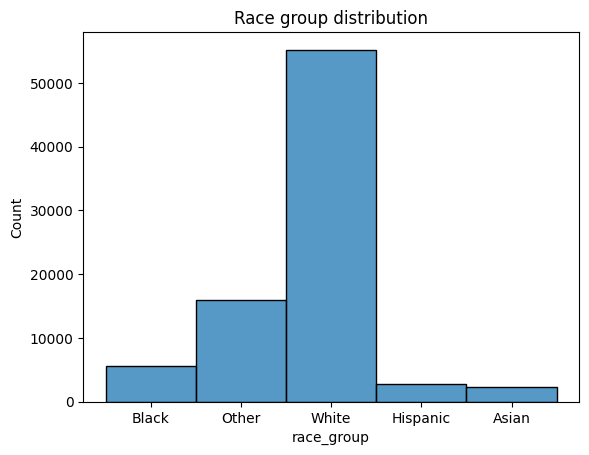

In [23]:
sns.histplot(data=df, x="race_group", kde=False)
plt.title('Race group distribution')
plt.show()

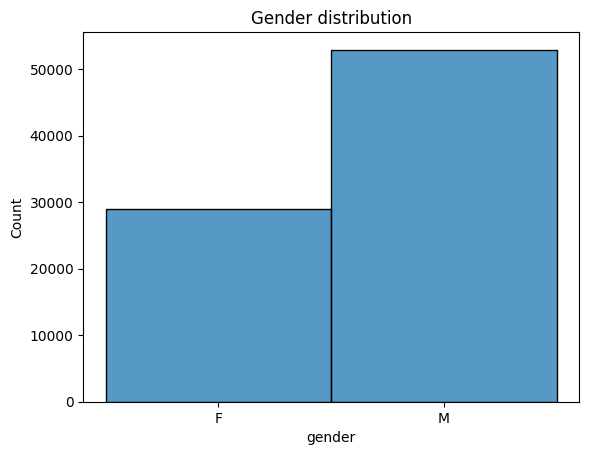

In [24]:
sns.histplot(data=df, x="gender", kde=False)
plt.title('Gender distribution')
plt.show()

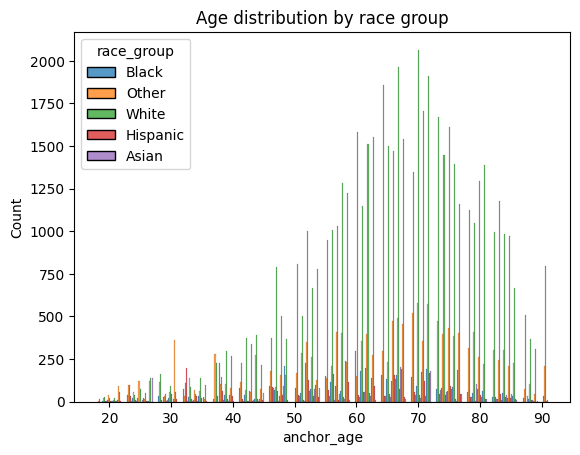

In [25]:
sns.histplot(data=df, x="anchor_age", hue="race_group", multiple="dodge")
plt.title('Age distribution by race group')
plt.show()

#### SaO2

In [26]:
def plot_groupby(df, group1, group2, variable, barplot=True, boxplot=True, violinplot=False):

  """
  This function creates two plots that compare the average values of a variable for two groups in a pandas dataframe.
  The function allows the user to choose between a bar plot, box plot, and violin plot for each group.
  The first plot compares the averages for the first group, and the second plot compares the averages for the second group.
  
  Inputs:
  df: pandas dataframe
  group1: string, name of the first categorical variable to group by
  group2: string, name of the second categorical variable to group by
  variable: string, name of the numerical variable to plot
  barplot: boolean, optional, default True. Whether to plot bar plots or not
  boxplot: boolean, optional, default True. Whether to plot box plots or not
  violinplot: boolean, optional, default False. Whether to plot violin plots or not
  
  Outputs: 
  None
  """

  avg_by_group1 = df.groupby(group1)[variable].mean()
  avg_by_group2 = df.groupby(group2)[variable].mean()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  
  if barplot:
    # Bar plot
    print('Bar Plot: ')
    ax1.bar(avg_by_group1.index, avg_by_group1.values)
    ax1.set_xlabel(group1)
    ax1.set_ylabel(f'Average {variable}')
    ax2.bar(avg_by_group2.index, avg_by_group2.values)
    ax2.set_xlabel(group2)
    ax2.set_ylabel(f'Average {variable}')
    plt.show()

  if boxplot:
    # Create box plots to visualize the distribution of SaO2 values by gender and ethnicity
    print('Box Plot: ')
    sns.boxplot(x=group1, y=variable, hue=group2, data=df)
    plt.show()

  if violinplot:
    print('Violin Plot: ')
    sns.violinplot(x=group1, y=variable, hue=group2, data=df)
    plt.show()


Bar Plot: 


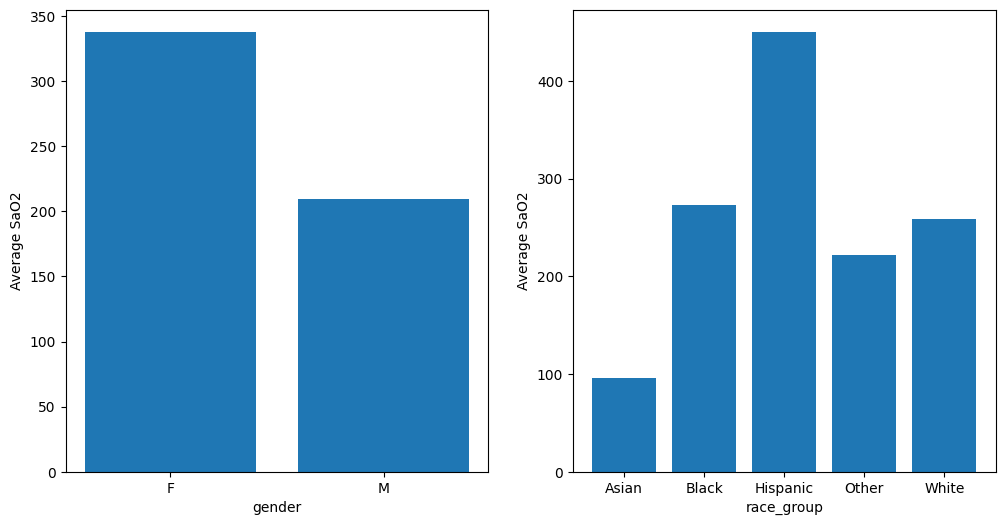

Box Plot: 


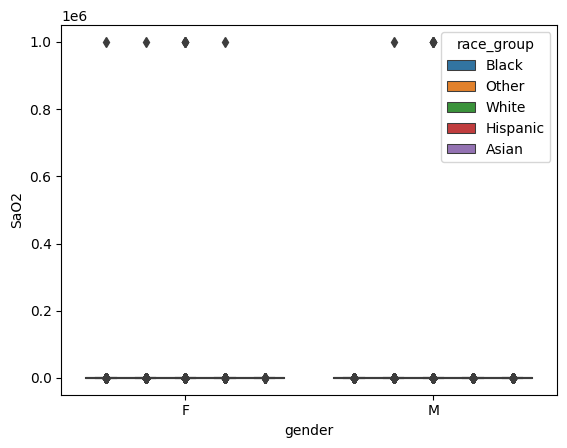

In [27]:
plot_groupby(df, group1='gender', group2='race_group', variable='SaO2')

##### Alert: While there are no missing values in SaO2. There are a number of very high values well above what they should be (between 0 and 100). That explains why we have such high average values. This tells us that the values in 99999 are possibly missing values.

In [28]:
outliers = 100

df['SaO2'] = df['SaO2'].apply(lambda x: np.nan if x > outliers else x)
#df['SaO2']

Bar Plot: 


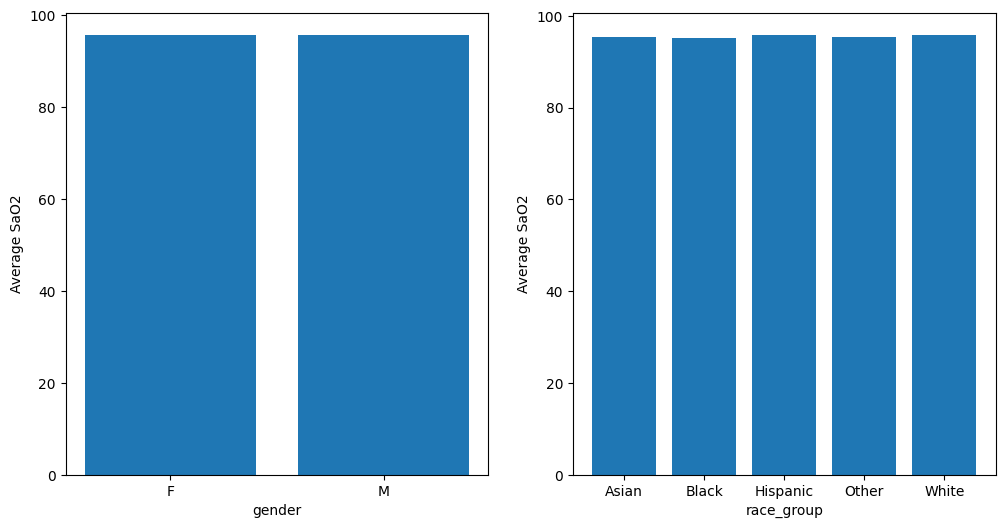

Box Plot: 


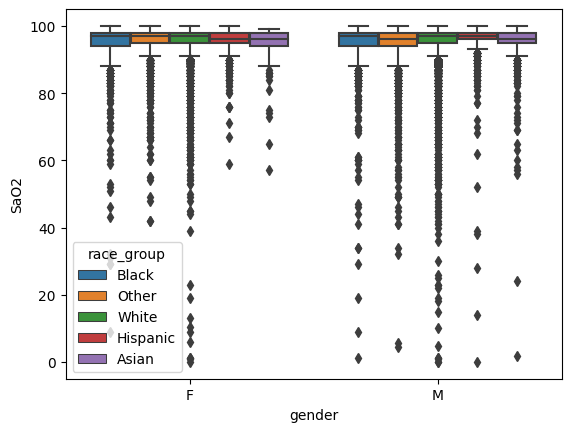

In [29]:
plot_groupby(df, group1='gender', group2='race_group', variable='SaO2')

#### SpO2

Bar Plot: 


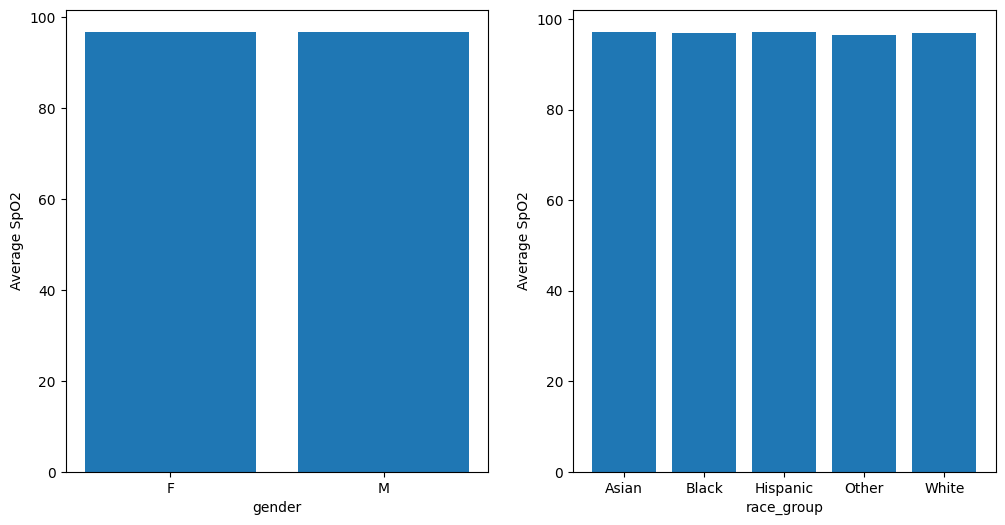

Box Plot: 


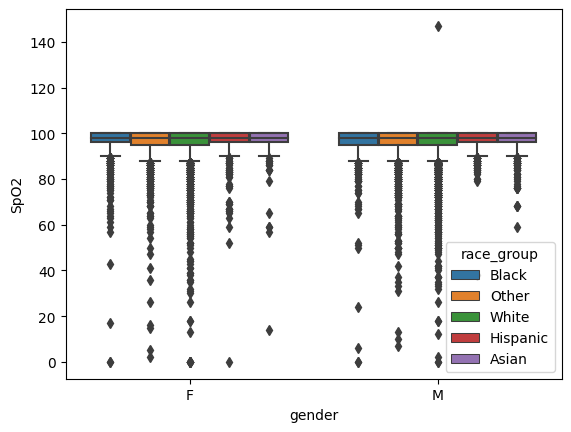

In [30]:
plot_groupby(df, group1='gender', group2='race_group', variable='SpO2')

In [31]:
outliers = 100

df['SpO2'] = df['SpO2'].apply(lambda x: np.nan if x > outliers else x)
#df['SpO2']

#### Time Offset

In [32]:
for column in df.columns:
  if 'delta' in column:
    print(column)

delta_sofa_resp
delta_SpO2
delta_vent_start
delta_ld_ldh
delta_albumin


Bar Plot: 


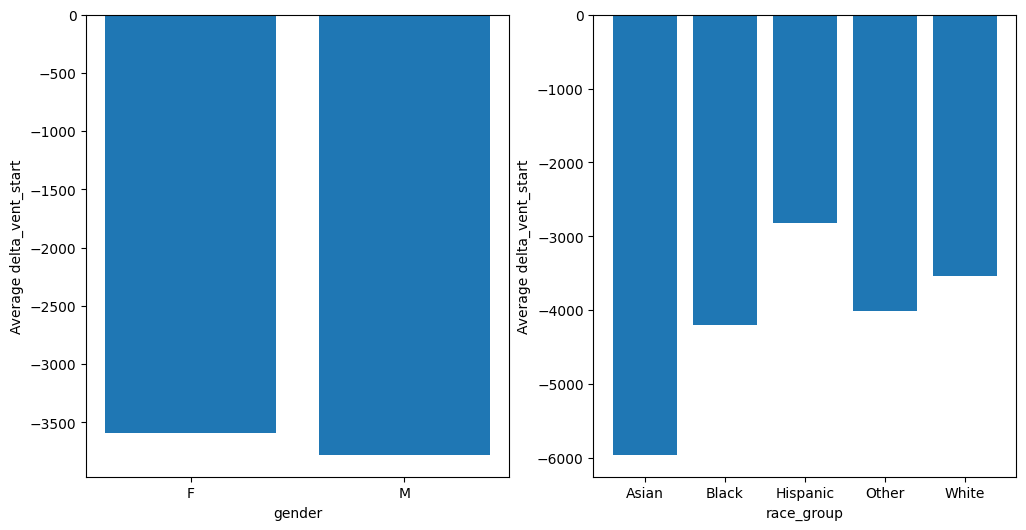

Violin Plot: 


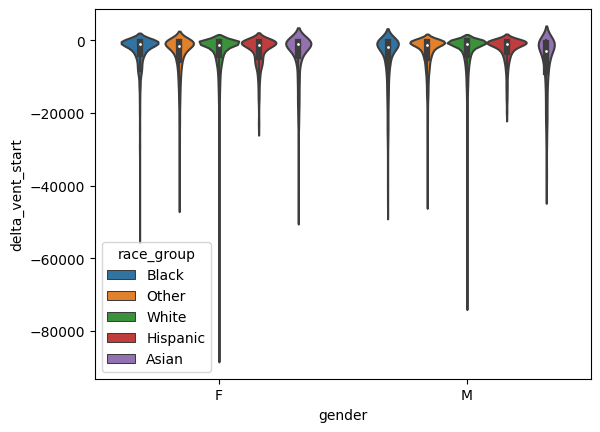

In [33]:
plot_groupby(df, group1='gender', group2='race_group', variable='delta_vent_start', barplot=True, boxplot=False, violinplot=True)

Bar Plot: 


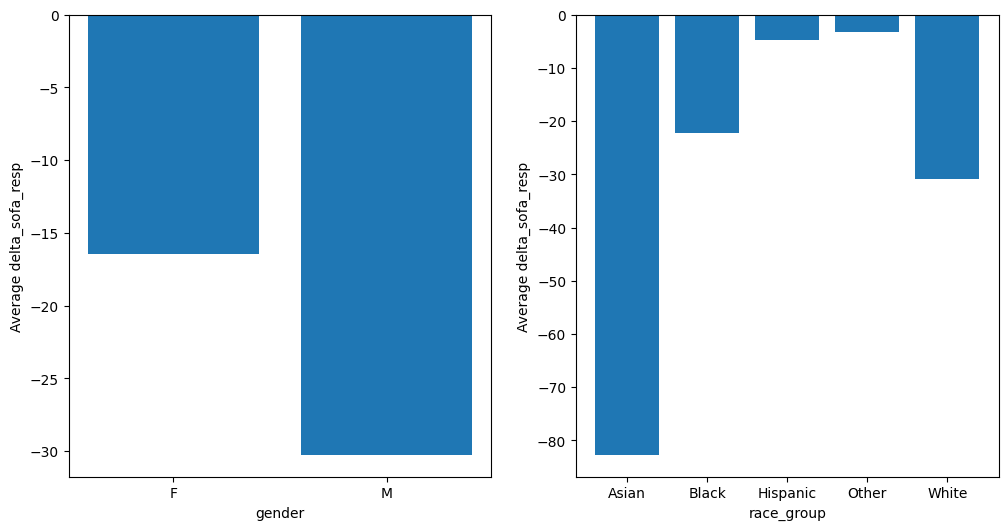

Violin Plot: 


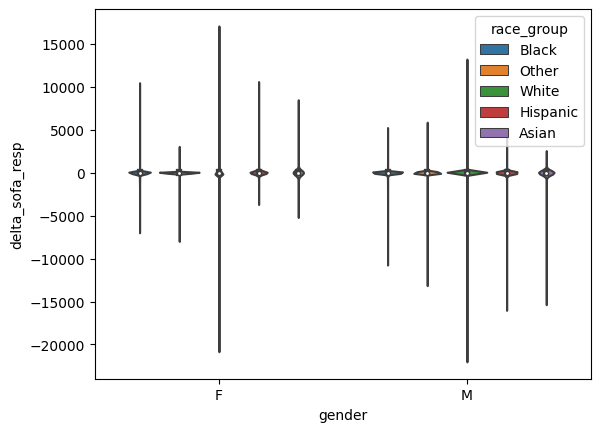

In [34]:
plot_groupby(df, group1='gender', group2='race_group', variable='delta_sofa_resp', barplot=True, boxplot=False, violinplot=True)

## Preprocessing

We know that there are some outliers so let's assume that those values al missing values and then analyze the amount of missing values for preprocessing

### Missing values

<Axes: >

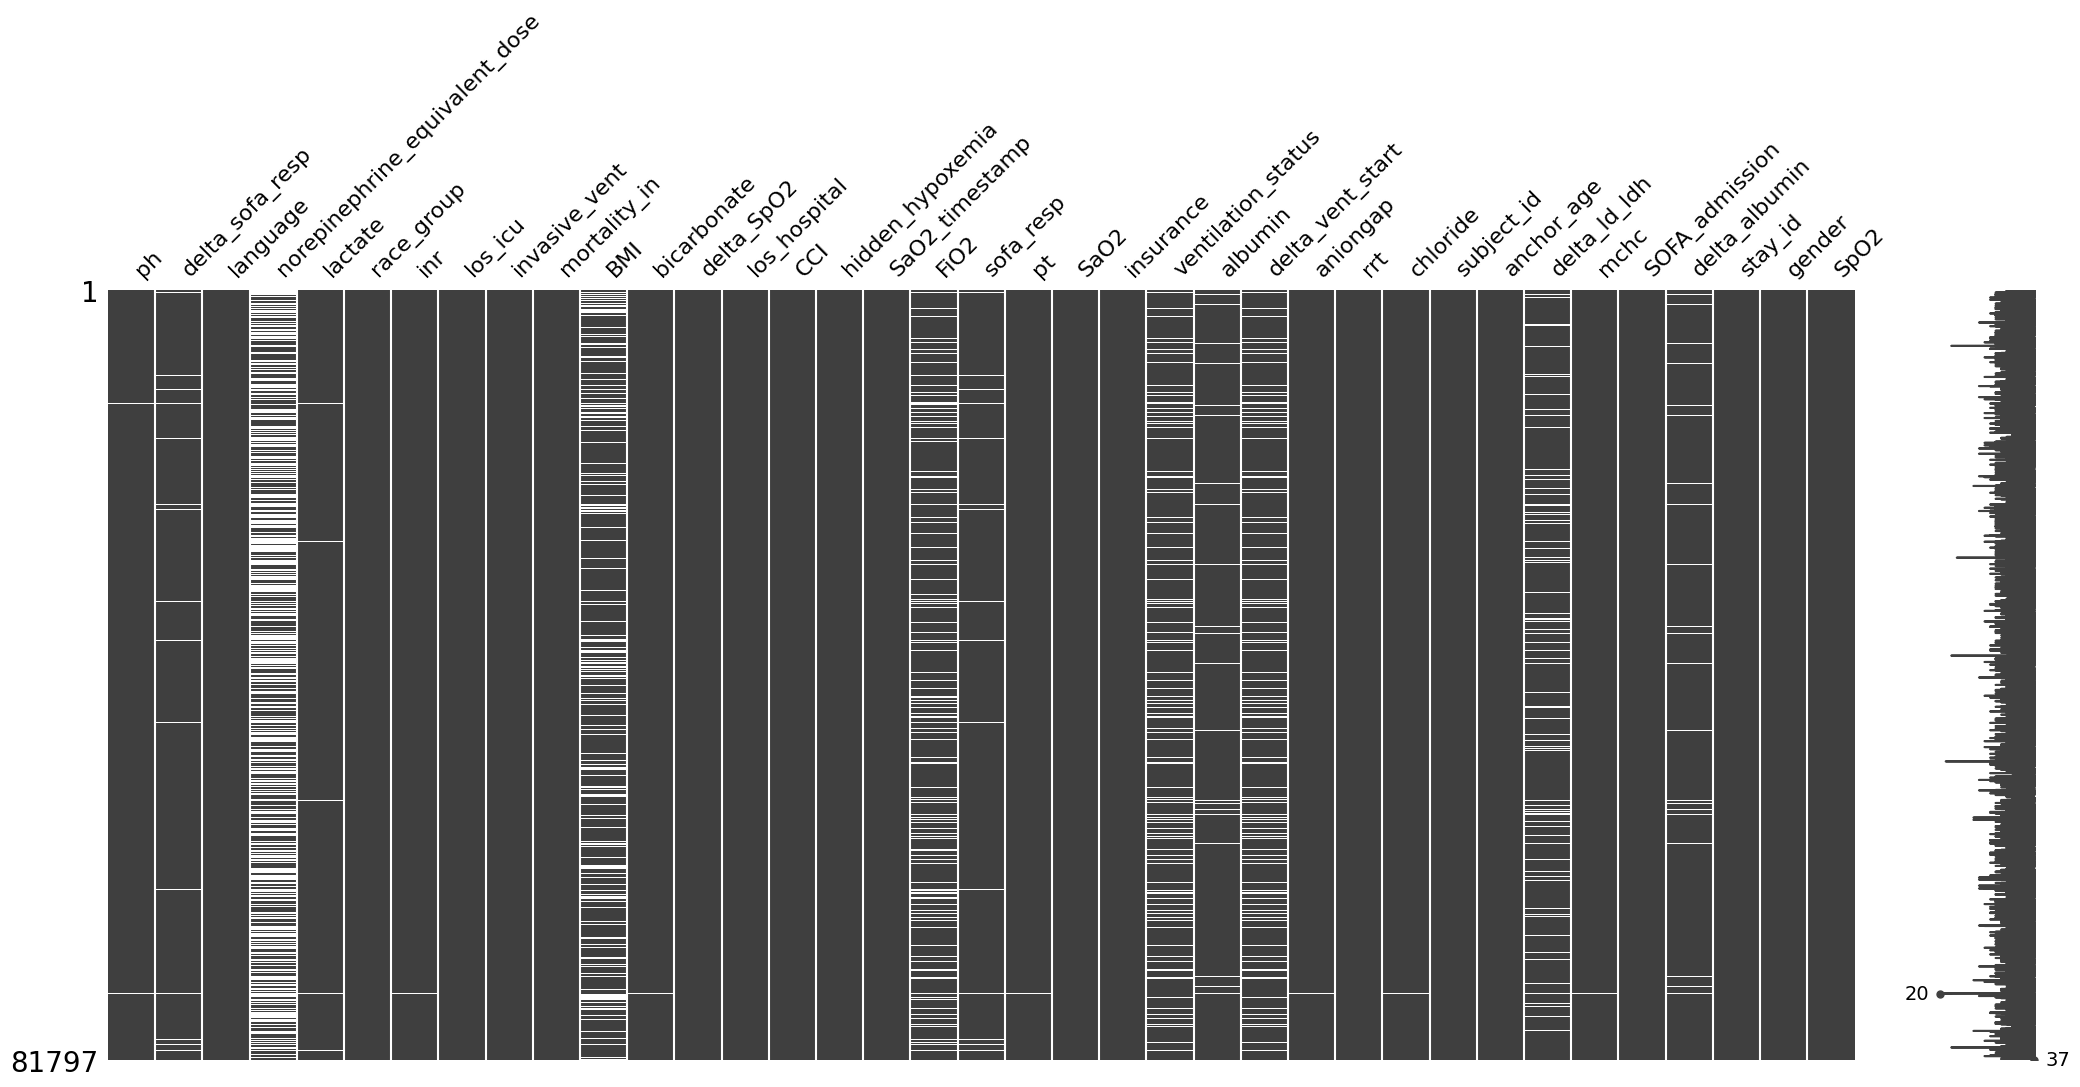

In [35]:
msno.matrix(df)

In [36]:
### List of columns with mussing values ###
null_values(df)

Null values: 
ph                                   64
delta_sofa_resp                    1968
norepinephrine_equivalent_dose    42002
lactate                             326
inr                                  65
BMI                               15958
bicarbonate                          50
FiO2                              11414
sofa_resp                          1968
pt                                   65
SaO2                                 26
ventilation_status                10070
albumin                            2857
delta_vent_start                  10070
aniongap                             50
chloride                             50
delta_ld_ldh                       8931
mchc                                 47
delta_albumin                      2857
SpO2                                  1
dtype: int64


### Data Imputation

There are various imputation methods of different complexity, ranging from imputing using the most common value (mode) (usually used for categorical variables) or the average or median value depending on the distribution of the data (usually used for numerical variables), to imputation methods using machine learning algorithms to predict the missing value using the other variables as a reference. While any method of data imputation can be valid, you have to take care to avoid data leakage or adding bias when doing this process.

As we have the columns with missing data, let's divide the columns into two sub groups:
1. Categorical columns with missing
2. Numerical columns with missing

In [37]:
# Get numerical and categorical columns:
categorical_cols, numerical_cols = get_categorical_numerical_variables(df, limit=10, ignore=ignore, verbose=False)

In [38]:
# Get the columns with missing data
columns_missing = df.isnull().sum()[df.isnull().sum() > 0].index
columns_missing

Index(['ph', 'delta_sofa_resp', 'norepinephrine_equivalent_dose', 'lactate',
       'inr', 'BMI', 'bicarbonate', 'FiO2', 'sofa_resp', 'pt', 'SaO2',
       'ventilation_status', 'albumin', 'delta_vent_start', 'aniongap',
       'chloride', 'delta_ld_ldh', 'mchc', 'delta_albumin', 'SpO2'],
      dtype='object')

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

def apply_data_imputation(df, groupby_cols, impute_cols, method='model', model=LinearRegression()):

  """
  Apply data imputation on missing values of columns by groupby the given columns.

  Important!!! 
  If you apply other technique than `new_category` on categorical variables
  or `new_category_numeric` on numerical variables. You should do it 
  ONLY AFTER train-test split otherwise you could be introducing a data leakage in the test set.

  Inputs:
  df: Pandas DataFrame with the input data to apply data imputation.
  groupby_cols: list with the column names to groupby the data.
  impute_cols: list with the column names to apply data imputation.
  method: str with the method to apply data imputation. Available options are 'median', 'mean', 'mode', 'new_category', 'new_category_numeric' and 'model'.
  model: sklearn model used to predict the missing value if method == 'model'

  Output:
  Pandas DataFrame with the data after applying data imputation on missing values of columns.
  """

  for col in impute_cols:
      
    # Group the data and calculate the method (E.g. Median) for each group
    if method == 'median':
      # Impute using median (for numerical values)
      imputation_values = df.groupby(groupby_cols)[col].median()

    elif method == 'mean':
      # Impute using mean (for numerical values)
      imputation_values = df.groupby(groupby_cols)[col].mean()

    elif method == 'mode':
      # Impute using mode (for categorical values)
      imputation_values = df.groupby(groupby_cols)[col].agg(pd.Series.mode)

    elif method == 'new_category':
      # Add a new category 'None' in the dataset (for categorical values)
      new_category_val = 'None'
      df[col] = df[col].fillna(new_category_val)

    elif method == 'new_category_numeric':
      # Add an anomalous data in the dataset (for numerical values)
      new_category_val = 0
      # If there's not 0, replace nan with 0
      if not((df[col] == 0).any()):
        new_category_val = 0
      # If there's not positive numbers, replace nan with 1
      elif not((df[col] >= 0).any()):
        new_category_val = 1
      # If there's not negative numbers, replace nan with 1
      elif not((df[col] <= 0).any()):
        new_category_val = -1
      else:      
        # Replace with min value - 100
        new_category_val = df[col].min() - 100
      df[col] = df[col].fillna(new_category_val)

    elif method == 'model':
      # If the variable is categorical, convert to numeric:
      if df[col].dtype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])

      # Create a linear regression model to impute missing values
      model = model

      # Get the data with complete column
      complete_data = df.dropna(subset=[col])

      # Encode categorical columns if needed in x data
      for col_group in groupby_cols:
        if df[col_group].dtype == 'object':
          le = LabelEncoder()
          complete_data[col_group] = le.fit_transform(complete_data[col_group])

      # Fit the model on the complete data
      X = complete_data[groupby_cols]
      # Replace any remaining NaNs with the column mean
      X = X.fillna(X.mean())
      y = complete_data[col]
      model.fit(X, y)

      # Impute column using the model to predict the value:
      missing_data = df[df[col].isna()]

      # Encode categorical columns if needed in x data
      for col_group in groupby_cols:
        if missing_data[col_group].dtype == 'object':
          missing_data[col_group] = le.transform(missing_data[col_group])

      for index, row in missing_data.iterrows():
          values = row[groupby_cols].values.reshape(1, -1)
          imputed_value = model.predict(values)
          df.at[index, col] = imputed_value[0]
          
    if method in ['median', 'mean', 'mode']:
      # Fill missing values with the method of the corresponding group
      df[col] = df.apply(lambda x: imputation_values[tuple(x[groupby_cols])] if pd.isna(x[col]) else x[col], axis=1)

  return df


#### 1. Categorical columns with missing

In [40]:
# Get from columns with missing data the categorical columns
categorical_cols_missing = [column for column in categorical_cols if column in columns_missing]
categorical_cols_missing

['sofa_resp', 'ventilation_status']

**⚠⚠⚠ Important! If you apply other technique than `new_category` on categorical variables. You should do it after train-test split otherwise you could be introducing a data leakage in the test set**

In [41]:
groupby_cols = ['race_group', 'gender']
method = 'new_category' # 'mode', 'new_category'

df = apply_data_imputation(df, groupby_cols, impute_cols=categorical_cols_missing, method=method)

#### 2. Numerical columns with missing

In [42]:
# Get from columns with missing data the numerical columns
numerical_cols_missing = [column for column in numerical_cols if column in columns_missing]
numerical_cols_missing

['ph',
 'delta_sofa_resp',
 'norepinephrine_equivalent_dose',
 'lactate',
 'inr',
 'BMI',
 'bicarbonate',
 'FiO2',
 'pt',
 'SaO2',
 'albumin',
 'delta_vent_start',
 'aniongap',
 'chloride',
 'delta_ld_ldh',
 'mchc',
 'delta_albumin',
 'SpO2']

**⚠⚠⚠ Important!!! If you apply other technique than `new_category_numeric` on numerical variables. You should do it after train-test split otherwise you could be introducing a data leakage in the test set**

In [43]:
groupby_cols = ['race_group', 'gender']
method = 'new_category_numeric' # 'median', 'mean', 'new_category_numeric', 'model'
df = apply_data_imputation(df, groupby_cols, impute_cols=numerical_cols_missing, method=method)

In [44]:
### List of columns with mussing values ###
null_values(df)

There aren't null values in the dataframe


### Encoding

Since the machine learning model in the background models and finds patterns in our data. It only supports numeric values. For this reason, categorical variables must be coded to numeric values.

In [45]:
print(f'Categorical: {categorical_cols}')

Categorical: ['language', 'invasive_vent', 'mortality_in', 'hidden_hypoxemia', 'sofa_resp', 'insurance', 'ventilation_status', 'rrt', 'gender']


In [46]:
for column in categorical_cols:
  print(f"Column '{column}' has values: {pd.unique(df[column])}")

Column 'language' has values: ['Proficient' 'Limited Proficiency']
Column 'invasive_vent' has values: [0 1]
Column 'mortality_in' has values: [1 0]
Column 'hidden_hypoxemia' has values: [0 1]
Column 'sofa_resp' has values: [2.0 1.0 3.0 0.0 'None' 4.0]
Column 'insurance' has values: ['Medicare' 'Other' 'Medicaid']
Column 'ventilation_status' has values: ['NonInvasiveVent' 'InvasiveVent' 'SupplementalOxygen' 'None' 'HFNC'
 'Tracheostomy']
Column 'rrt' has values: [0 1]
Column 'gender' has values: ['F' 'M']


In [47]:
df['sofa_resp'] = df['sofa_resp'].replace({'None': -1})
df['gender'] = df['gender'].replace({'F':1, 'M':0})
df['language'] = df['language'].replace({'Proficient':1, 'Limited Proficiency':0})

In [48]:
# convert 'insurance' column into one-hot encoding
one_hot = pd.get_dummies(df['insurance'])
# add the one-hot encoded columns to the DataFrame
df = pd.concat([df, one_hot], axis=1)
# drop the original 'insurance' column
df = df.drop('insurance', axis=1)

In [49]:
# convert 'ventilation_status' column into one-hot encoding
df['ventilation_status'] = df['ventilation_status'].replace({'None': 'None_ventilation'})
one_hot = pd.get_dummies(df['ventilation_status'])
# add the one-hot encoded columns to the DataFrame
df = pd.concat([df, one_hot], axis=1)
# drop the original 'ventilation_status' column
df = df.drop('ventilation_status', axis=1)

### Feature Engineering

Once we have cleaned the dataset we can engineer the features that can provide more information to the model to generate the predictions.

We'll print the correlation to SpO2 as a reference to see the most correlated variables before and after generating the new features.

In [50]:
# Get variables correlated to SpO2
columns_sao2 = get_most_correlated(df, variable='SpO2', n=5)

########################################  SpO2  ########################################
The 5 most correlated variables to variable SpO2 are: 
SpO2        1.000000
SaO2        0.278054
chloride    0.090712
albumin     0.084336
ph          0.069232
Name: SpO2, dtype: float64
The 5 most inversely correlated variables to variable SpO2 are: 
FiO2                             -0.120172
norepinephrine_equivalent_dose   -0.122767
mortality_in                     -0.136693
aniongap                         -0.169667
sofa_resp                        -0.258002
Name: SpO2, dtype: float64


In [51]:
# Length of ICU stay in days for dead
df['los_icu_dead'] = df[df.mortality_in == 1].los_icu
# Length of ICU stay in days for survivors
df['los_icu_surv'] = df[df.mortality_in == 0].los_icu

In [52]:
# Get variables correlated to SpO2
columns_sao2 = get_most_correlated(df, variable='SpO2', n=5)

########################################  SpO2  ########################################
The 5 most correlated variables to variable SpO2 are: 
SpO2            1.000000
SaO2            0.278054
los_icu_dead    0.129044
chloride        0.090712
albumin         0.084336
Name: SpO2, dtype: float64
The 5 most inversely correlated variables to variable SpO2 are: 
FiO2                             -0.120172
norepinephrine_equivalent_dose   -0.122767
mortality_in                     -0.136693
aniongap                         -0.169667
sofa_resp                        -0.258002
Name: SpO2, dtype: float64


Surprise! we can see how before the correlation `los_icu` and `mortality_in` were not there, but after the feature engineering the new feature `los_icu_dead` is there! 

That shows the importance of being able to do good feature engineering.

# TODO: 
- Data Normalization
- Class Imbalance

Finally let's save the dataset as a csv file! 😀

In [53]:
df

,ph,delta_sofa_resp,language,norepinephrine_equivalent_dose,lactate,race_group,inr,los_icu,invasive_vent,mortality_in,...,Medicare,Other,HFNC,InvasiveVent,NonInvasiveVent,None_ventilation,SupplementalOxygen,Tracheostomy,los_icu_dead,los_icu_surv
0,7.38,56.0,1,0.0000,1.1,Black,1.1,9.17,0,1,...,1,0,0,0,1,0,0,0,9.17,NaN
1,7.42,32.0,1,0.0000,1.2,Black,1.1,9.17,0,1,...,1,0,0,0,1,0,0,0,9.17,NaN
2,7.33,57.0,1,0.0000,2.6,Other,1.0,1.29,1,0,...,1,0,0,1,0,0,0,0,NaN,1.29
3,7.33,18.0,1,0.0000,2.6,Other,1.0,1.29,1,0,...,1,0,0,1,0,0,0,0,NaN,1.29
4,7.35,28.0,1,0.0000,2.6,Other,1.0,1.29,0,0,...,1,0,0,0,0,0,1,0,NaN,1.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81792,7.38,48.0,1,0.0000,0.8,Black,1.1,4.67,1,1,...,1,0,0,1,0,0,0,0,4.67,NaN
81793,7.46,9.0,1,0.0000,1.5,White,1.2,5.29,1,1,...,0,1,0,1,0,0,0,0,5.29,NaN
81794,7.40,30.0,1,0.0700,1.5,White,1.2,5.29,1,1,...,0,1,0,1,0,0,0,0,5.29,NaN
81795,7.42,49.0,1,0.1704,1.5,White,1.2,5.29,1,1,...,0,1,0,1,0,0,0,0,5.29,NaN


In [54]:
df.to_csv('oxygen_dataset/preprocessed_MIMIC_IV.csv', index=False)
# Or with the right format
# df.to_csv('oxygen_dataset/data_clean.csv', index=False)

# Thank you very much and good luck!!

Your mentors:

- David Restrepo: davidres@mit.edu
- Adrien Carrel: a.carrel@hotmail.fr
- Jack Gallifant: jack.gallifant@nhs.net